# Convection-Diffusion Equation 1D - Comprobación de que funciona bien

# Case 6: Upwind with three points: Implicit

We try to approximate the solution of
\begin{align}
\partial_t u - \nu \partial^2_{xx} u + \beta \partial_{x} u &= f \quad\text{in } \Omega=(a,b) \times (0,T),
\\
\partial_t u \cdot n &= 0\quad\text{on } \partial\Omega,
\end{align}
where $(a,b)\subset\mathbb{R}$ is an interval, $T>0$ is a given final time and $f\in C([a,b] \times (0,T))$.

En este caso el término convectivo va a ser $\nabla \cdot (u \nabla v)$, es decir, $(u v_x)_x$. Así que, por un lado tenemos que aproximar numéricamente $v_x$ y por otro lado habría que aproximar numéricamente la derivada "de fuera". Vamos a usar esquemas progresivos en ambos (estamos aproximando sin tener ninguna evidencia teórica que apoye una elección o no).

Llamemos $v_x \sim \beta_i^m$. Entonces el esquema aproximado quedará $(u \beta_i^m)_x \sim \frac{u_{i+1}^m \beta_{i+1}^m - u_i^m \beta_i^m}{h}$ y donde $\beta_i^m = \frac{v_{i}^m - v_{i-1}^m}{h}$.

Let us consider the mesh $x_i=a+h i$, for  $i=0,...,n+1$, with $h=(b-a)/(n+2)$, and the time partition $t_m = km$, $m=0,...,M$ whith $k=T/M$.

We define the problem: given $u_{i,j}^{m-1}$, $m\ge 1$, find $u_{i}^m \simeq u(x_i, t_m)$ such that

$$
\frac 1 k u_{i}^m 
- \nu \frac{ u_{i+1}^m - 2u_{i}^m + u_{i-1}^m}{h^2} + \frac{\beta_{i+1}^m u_{i+1}^m - \beta_i^m u_i^m}{h}
=
f^m_{i} + \frac 1 k u_{i}^{m-1},
$$
or
$$
\Big(\frac 1 k + \frac{2\nu}{h^2} - \frac{\beta_i^m}{h} \Big) u_{i}^m 
- \Big( \frac{\nu}{h^2} - \frac{\beta_{i+1}^m }{h} \Big) u_{i+1}^m
- \frac{\nu}{h^2} u_{i-1}^m
=
f^m_{i} + \frac 1 k u_{i}^{m-1},
$$
or
$$
\Big(1+ 2 \frac {k\nu}{h^2} - \beta_i^m
\frac{k}{h} \Big) u_{i}^m 
- \Big( \frac {k\nu}{h^2} - \beta_{i+1}^m \frac{k}{h} \Big) u_{i+1}^m
- \frac {k\nu}{h^2} \, u_{i-1}^m
=
k f^m_{i} + u_{i}^{m-1},
$$

It can be written as the system
$AU=F$ with 

\begin{aligned}
U=( u^m_{1},u^m_{2},...,u^m_{n}),
\\
F_{i}=k f^m_{i} + u_{i}^{m-1}
\end{aligned}
and
$$
A=
\begin{pmatrix}
   a & -b &  0 &  0 & \dots & & & 0 & 0 \\
  -c &  a & -b &  0 & \dots & & & 0 & 0\\
   0 & -c &  a & -b & \dots & & & 0 & 0 \\
   \vdots &    & \ddots & \ddots & \ddots & \\
   0 & 0 & \dots & -c & a  & -b \\
   0 & 0 &  0 & \dots & -c & a  & -b \\
     & & &&    & \ddots & \ddots & \ddots & \\
   0 & \dots & &  & & & 0 & a & -b \\ 
   0 & \dots & &  & & &  & -c & a \\
 \end{pmatrix},
$$
siendo:
\begin{align*}
  a&= 1 + 2\frac {k\nu}{h^2} - \beta_i^m \frac{k}{h}, \\
  b&=\frac {k\nu}{h^2} - \beta_{i+1}^m \frac{k}{h}, \\
  c&=\frac {k\nu}{h^2}.
\end{align*}
El vector diagonal $(d,d,\dots,d)$ está separado exactamente $n$
posiciones desde la diagonal de la matriz.

#### Problema

En este caso se nos presenta el problema que no podemos calcular el último elemento del vector $\beta$ porque se saldría del vector $v$.

En principio tenemos las siguientes soluciones para este problema:

1. Darle un valor aproximado al último punto que sí tenemos calculado

2. Tomar quizás una discretización en espacio de la concentración v con más puntos

3. Tomar un esquema centrado

#### Boundary conditions

Let $\Gamma_l=\{a\}$, $\Gamma_r=\{b\}$. Homogeneous Neumann b.c. can be approximated as follows:

* On $\Gamma_l$: $\partial_x u(a,t_m) \cdot n = \partial_x u(a,t_m) \cdot (-1) = -\partial_x   u(a,t_m) \simeq -\frac{u^m_{1}-u^m_{0}}{h}=0$,
* On $\Gamma_r$: $\nabla u(b,y_j,t_m) \times n = \nabla u(b,y_j,t_m) \times (1,0) = \partial_x   u(b,y_j,t_m) \simeq \frac{u^m_{n+1,j}-u^m_{n,j}}{h}=0$,

Then, boundary conditions can be approximated by defining, for each $m\ge 1$, the values $u^m_{0,j}=u^m_{1,j}$, $u^m_{n+1,j}=u^m_{n,j}$, $u^m_{i,0}=u^m_{i,1}$, $u^m_{i,n+1}=u^m_{i,n}$, $i,j=0,\dots,n+1$

In [1]:
import numpy as np
import matplotlib.pyplot as mpl
from numpy import diag, ones, linspace, array, reshape
from numpy.linalg import solve

In [2]:
def convection_diffusion_equation_neumann_1d(f, u_init, v, nx_intervals, nt_intervals, 
                             a, b, T, nu, verbosity):
    """
    Heat equatin with Homogeneous Neumann Boundary Conditions.
    * f: RHS
    * u_init: Initial function, u_init(x)
    * nu: Viscosity coefficient
    * a, b: interval (domain = (a,b))
    * T: Max. time (time interval = (0,T))
    * nx: space discretization, a=x_0,x_1,...,x_{nx}=b$
    * nt: time discretization, 0=t_0,t_1,...,t_{nt}=T$
    * v: vector with convective coefficient
    """
    
    # Space and time discretization
    nx_points = nx = nx_intervals+1
    h = (b-a)/nx_intervals # Space mesh size
    x = linspace(a, b, nx_points) # a = x_0, ..., x_{nx} = b
    
    k = T/nt_intervals # Time step
    t = linspace(0, T, nt_intervals+1) # 0 = t_0, t_1, ..., t_{nt} = T  

    if(verbosity>1):
        print("x=",x)
        print("t=",t)
        
    def plus(x):
        "Parte positiva del array x (o número real x)"
        return (x+abs(x))/2 # x[i] if x[i]>0, else 0
    def minus(x):
        "Parte negativa del array x (o número real x)"
        return (x-abs(x))/2 # x[i] if x[i]<0, else 0
    # def val_abs(v):
    #    "Valor absoluto del array v"
    #    for i in range(1, len(v)+1):
    #        v[i-1]=abs(v[i-1])
    #    return v 
        
    n=nx  # n_interior_x_points*n_interior_x_points
    
    c0 = (3*k)/(2*h)  # Diagonal coefficient a_{ii}
    c01 = 1 + 2*(k*nu)/h**2 # Coeficiente sin beta de a_{ii}
    c1 = (2*k)/h # Coeficiente de beta de u_{i-1,i}
    c11 = -(k*nu)/h**2 # Coeficiente sin beta de u_{i-1,i}
    c2 = -k/(2*h) # Coeficiente con beta de u_{i-2,i}
    c3 = -2*k/h # Coeficiente con beta de u_{i+1,i}
    c31 = -(k*nu)/h**2 # Coeficiente sin beta de u_{i+1,i}
    c4 = k/(2*h) # Coeficiente con beta de u_{i+2,i}
    
    if(verbosity>0): 
        print("c0=", c0)
        print("c01=", c01)
        print("c1=", c1)
        print("c11=", c11)
        print("c2=", c2)
        print("c3=", c3)
        print("c31=", c31)
        print("c4=", c4)
    
    # Matrix
    w1 = ones(NX)
    w2 = ones(NX)
    w3 = ones(NX-1)
    w4 = ones(NX-1)
    
    w1 = plus(v[0:-1])
    w2 = minus(v[0:-1])
    w3 = plus(v[0:-2])
    w4 = minus(v[0:-2])
    
    if(verbosity>0): 
        print("w1=", w1)
    if(verbosity>0): 
        print("w2=", w2)
    if(verbosity>0): 
        print("w3=", w3)
    if(verbosity>0): 
        print("w4=", w4)
    
    A = c0 * diag( abs(v) ) + c01 * diag(ones(n)) \
            +c1 * diag( w2, -1 ) + c11 * diag( ones(n-1), -1) \
            + c2 * diag( w4, -2 ) \
            + c3 * diag( w1, +1 ) + c31 * diag( ones(n-1), +1) \
            + c4 * diag( w3, +2 )
    if(verbosity>0): 
        print("nx=%i (h=%2.2f), nt=%i (k=%2.2f), n=(nx+1)^2=%i" % 
              (nx, h, nt_intervals, k, n) )
        print("A=\n", A, " ", end="" )
        print( np.shape(A) )
    
    # Set Neumann boundary c.
    A[0,0] = A[-1,-1] = 1
    A[0,1] = A[-1,-2] = -1
    
    # A[1,0] = -k/(h**2) + 2*minus(v[0])*(k/h)
    # A[1,1] = 1 + (3*k)/(2*h)*abs(v[1]) + (2*k)/(h**2) - k/(2*h)*minus(v[1])
    # A[1,2] = -k/(h**2) - (2*k)/h*plus(v[2])
    # A[1,3] = k/(2*h)*minus(v[3])
    
    A[1,0] = -k/(h**2) + 2*w2[0]*(k/h)
    A[1,1] = 1 + (3*k)/(2*h)*abs(v[1]) + (2*k)/(h**2) - k/(2*h)*minus(v[1])
    A[1,2] = -k/(h**2) - (2*k)/h*w1[1]
    A[1,3] = k/(2*h)*w3[1]
    
    
    # A[-2,-1] = -k/(h**2) - 2*plus(v[n-1])*(k/h)
    # A[-2,-2] = 1+(3*k)/(2*h)*abs(v[n-2]) + (2*k)/(h**2) + k/(2*h)*plus(v[n-2])
    # A[-2,-3] = -k/(h**2) + 2*minus(v[n-2])*(k/h)
    # A[-2,-4] = -k/(2*h)*minus(v[n-2])
    
    A[-2,-1] = -k/(h**2) - 2*w1[NX-1]*(k/h)
    A[-2,-2] = 1+(3*k)/(2*h)*abs(v[n-2]) + (2*k)/(h**2) + k/(2*h)*plus(v[n-2])
    A[-2,-3] = -k/(h**2) + 2*w2[NX-2]*(k/h)
    A[-2,-4] = -1*k/(2*h)*w4[NX-3]
    
    A[0,2]=0
    
    if(verbosity>0): 
        print("nx=%i (h=%2.2f), nt=%i (k=%2.2f), n=(nx+1)^2=%i" % 
              (nx, h, nt_intervals, k, n) )
        print("A=\n", A, " ", end="" )
        print( np.shape(A) )
    
    # Time iterations)
   
    U0 = u_init(x)
    if(verbosity>0):        
        print("U0 =", U0, " ", np.shape(U0) )    
    solution = [ U0 ]

    for m in range(1,nt_intervals+1):  # m=1, 1,..., nt
        current_t = t[m]
        if(verbosity>0):
            print("m=%i, current_t=%.2f" % (m,current_t))
        
        F = k*f(x, current_t) + U0
        
        # Set homogneous Neumann boundary c.
        F[0] = F[-1] = 0
      
        if(verbosity>0):        
            print("F=", F, " ", end="" )
            print( np.shape(F) )

        # 3. Resolver sistema
    
        U = solve(A, F) 
        if(verbosity>0):        
            print("U =", U, " ", np.shape(U) )
            from numpy import linalg as LA
            print("||U||_2 =", LA.norm(U))
        U0 = U
        solution.append(U)
        
    return solution, x, t

Define plotting function, RHS function f and initial condition

We provide two initial conditions for testing:
1. $u_0(x) = C$ (constant). The exact solution is $u(x,t)=u_0$ for all $t>0$.
2. $u_0(x) \ge 0$ is defined as a Gaussian (bell) function. Like for any initial condition, the function must converge (in $L^2$ norm) to a constant, $C_\infty\ge 0$, when $t\to\infty$. Specifically, it is not diffcult to show that
$
\| u(t) - u_0 \|_{L^2(\Omega)} \to 0
$
as $t\to\infty$, where $u_\infty$ is the mean oif $u$ in $\Omega$, i.e.
$$
u_\infty= \frac 1{|\Omega|} \int_\Omega u_0(x) dx \in\mathbb R
$$
where $|\Omega|$ is the meassure of $\Omega$.

In [3]:
def my_plot(x, y, t_iter):
    d = t_iter
    l = "$u(x,t_i),\quad i=%i$" % (t_iter)
    mpl.plot(x, y, lw=2, dashes=(5, d), label=l)
    
mpl.rcParams['figure.dpi'] = 100

# --------------------------------------------    
f = lambda x, t: np.zeros_like(x)

# Initial solution 1: u_0=cte (then u(x,t)=cte forall t>0)
u_cte = lambda x: 5*np.ones_like(x)

# Initial solution 2: u_0 = Gaussian function
C_gauss = 10
u_gauss = lambda x: np.exp(-C_gauss*(x**2))

In [16]:
NT = 5
NX = 50
X0 = -1
X1 = 1
x = linspace(X0, X1, NX+1)
vect = u_gauss(x)

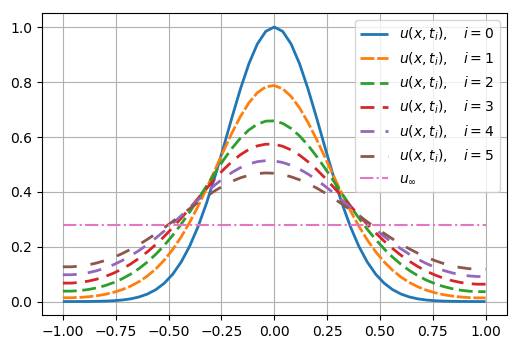

In [17]:
u, x, t = convection_diffusion_equation_neumann_1d(f, u_init=u_gauss, v=vect, 
                                    nx_intervals=NX, nt_intervals=NT, 
                                    a=X0, b=X1, T=0.1, nu=1, verbosity=0)

for i in range(NT+1):
    my_plot(x, u[i], i)
    #mpl.show()
u_infty = quad(u[0], x)/(X1-X0) # Media de u_0 en [a,b]
mpl.plot(x, u_infty*np.ones_like(x), "-.", label="$u_\infty$")
mpl.grid()    
mpl.legend()

In [6]:
NT = 1
NX = 4
X0 = -2
X1 = 2
x = linspace(X0, X1, NX+1)
u_cte = lambda x: 5*np.ones_like(x)
f = lambda x, t: np.zeros_like(x)
vect = u_cte(x)

c0= 1.5
c01= 3.0
c1= 2.0
c11= -1.0
c2= -0.5
c3= -2.0
c31= -1.0
c4= 0.5
w1= [5. 5. 5. 5.]
w2= [0. 0. 0. 0.]
w3= [5. 5. 5.]
w4= [0. 0. 0.]
nx=5 (h=1.00), nt=1 (k=1.00), n=(nx+1)^2=5
A=
 [[ 10.5 -11.    2.5   0.    0. ]
 [ -1.   10.5 -11.    2.5   0. ]
 [  0.   -1.   10.5 -11.    2.5]
 [  0.    0.   -1.   10.5 -11. ]
 [  0.    0.    0.   -1.   10.5]]  (5, 5)
nx=5 (h=1.00), nt=1 (k=1.00), n=(nx+1)^2=5
A=
 [[  1.   -1.    0.    0.    0. ]
 [ -1.   10.5 -11.    2.5   0. ]
 [  0.   -1.   10.5 -11.    2.5]
 [  0.   -0.   -1.   13.  -11. ]
 [  0.    0.    0.   -1.    1. ]]  (5, 5)
U0 = [5. 5. 5. 5. 5.]   (5,)
m=1, current_t=1.00
F= [0. 5. 5. 5. 0.]  (5,)
U = [5. 5. 5. 5. 5.]   (5,)
||U||_2 = 11.180339887498949


NameError: name 'quad' is not defined

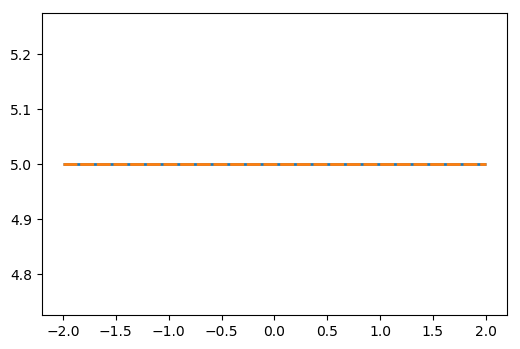

In [7]:
u, x, t = convection_diffusion_equation_neumann_1d(f, u_init=u_cte, v=vect, 
                                    nx_intervals=NX, nt_intervals=NT, 
                                    a=X0, b=X1, T=1, nu=1, verbosity=1)

for i in range(NT+1):
    my_plot(x, u[i], i)
    #mpl.show()
u_infty = quad(u[0], x)/(X1-X0) # Media de u_0 en [a,b]
mpl.plot(x, u_infty*np.ones_like(x), "-.", label="$u_\infty$")
mpl.grid()    
mpl.legend()

In [8]:
u

[array([5., 5., 5., 5., 5.]), array([5., 5., 5., 5., 5.])]

### Compruebo que $\|u(i)-u_\infty\| \to 0$

In [9]:
def quad(y, x):
    """
    Fórmula de cuadratura de los trapecios compuesta para aproximar la integral
    de la función dada por los valores y_0, y_1, ..., y_{n-1} sobre los 
    nodos x_0, x_1,... x_{n-1}
    """
    h = x[1]-x[0]
    sum = np.sum(y[1:-2]) # f(x_1) + ... + f(x_{n-2})
    return h*( y[0]/2 + sum + y[-1]/2 )

# Test: integral de f(x)=1
valores_y = np.ones_like(x) # Array [1,1,1....1] (del tamaño de x)
integral_aprox = quad(valores_y, x )

print(" Intervalo [%.2f,%.2f], aproximación de la integral de f(x)=1:  %f" 
     % (x[0], x[-1], integral_aprox))

 Intervalo [-2.00,2.00], aproximación de la integral de f(x)=1:  3.000000


Mean of u_infty: 3.7500000000000000
||u(t_0) - u_infty|| =  2.1650635094610968 


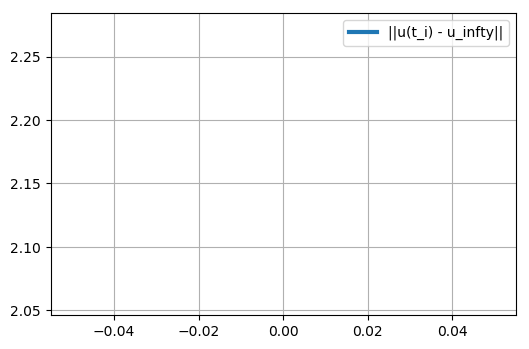

In [10]:
a, b = X0, X1
u_infty = quad(u[0], x)/(b-a) # Media de u_0 en [a,b] 

print("Mean of u_infty: %.16f" % (u_infty) )
errores_L2 = []
for i in range(0,NT):
    error_L2_cuadrado = quad( (u[i]-u_infty)**2, x)
    error_L2 = np.sqrt( error_L2_cuadrado )
    print ("||u(t_%i) - u_infty|| =  %.16f " % (i, error_L2) )
    errores_L2.append( error_L2 )
    
mpl.plot(range(NT), errores_L2, lw=3, label="||u(t_i) - u_infty||")
mpl.legend()
mpl.grid()

In [11]:
p = lambda x: 2*x
x = linspace(-1,1,10)
p(x)

array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
        0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ])

In [12]:
abs(p(x))

array([2.        , 1.55555556, 1.11111111, 0.66666667, 0.22222222,
       0.22222222, 0.66666667, 1.11111111, 1.55555556, 2.        ])

In [13]:
def plus(x):
        "Parte positiva del array x (o número real x)"
        return (x+abs(x))/2 # x[i] if x[i]>0, else 0
def minus(x):
    "Parte negativa del array x (o número real x)"
    return (x-abs(x))/2 # x[i] if x[i]<0, else 0
v = array([1,1,1,1,1])
w1 = ones(5)
w2 = ones(5)
w3 = ones(4)
w4 = ones(4)
    
w1 = plus(v[0:-1])
w2 = minus(v[0:-1])
w3 = plus(v[0:-2])
w4 = minus(v[0:-2])
w1

array([1., 1., 1., 1.])

In [14]:
A = 3 * diag( abs(v) ) + 2 * diag(ones(5)) \
        +1 * diag( w1, -1 ) + 2 * diag( ones(5-1), -1) \
        + 4 * diag( w3, -2 ) \
        + 5 * diag( w2, +1 ) + 6 * diag( ones(5-1), +1) \
        + 7 * diag( w4, +2 )
A

array([[5., 6., 0., 0., 0.],
       [3., 5., 6., 0., 0.],
       [4., 3., 5., 6., 0.],
       [0., 4., 3., 5., 6.],
       [0., 0., 4., 3., 5.]])

In [15]:
z = ones(5)
z

array([1., 1., 1., 1., 1.])